# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Introducción

En este proyecto, se busca la predicción del número de pedidos de taxis utilizando técnicas de ML y series temporales. Los datos a utilizar corresponden a registros de pedidos de taxis por hora, en los cuales el objetivo sera predecir la cantidad de pedidos en base a varias características temporales. Para lograrlo, se implementaran diferentes modelos de regresión y se compararan sus resultados para identificar el modelo más adecuado en cuanto a precisión.

## Preparación y Análisis Exploratorio de los Datos 



In [1]:
# se importan las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression   
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb


Se cargan los datos, se pone como indice la columna 0 y se pone como datos datetime, finalmente se ordena.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

Se verifican los tipos de datos y  posibles valores nulos, ademas de ver el rango de fecha en los datos con las funciones head y tail.

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
                     num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


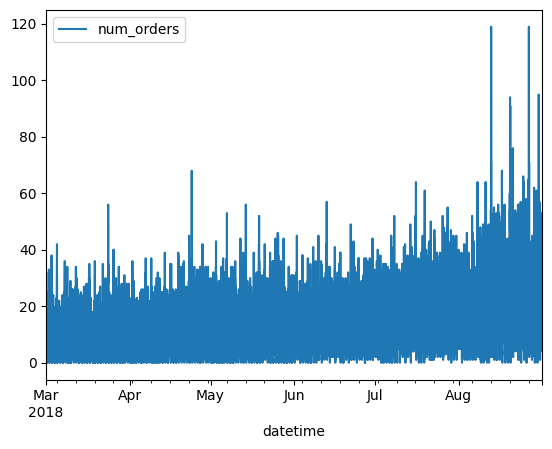

In [3]:
print(df.head())
print(df.tail())
df.plot()
df.info()

Se remuestrean los datos para que cada punto de datos represente el número de pedidos en intervalos de una hora. 

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


<AxesSubplot:xlabel='datetime'>

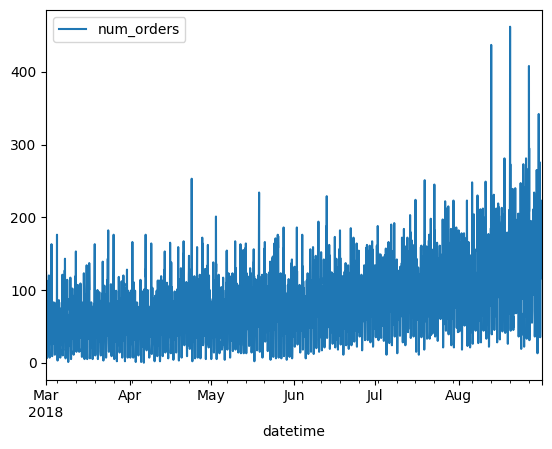

In [4]:
df_hour = df.resample('1H').sum()
print(df_hour.head())
df_hour.plot()


Se agrega una columna con la media móvil para reducir las fluctuaciones en una serie temporal. se tomara como tamaño de ventana los datos de un día (24).

                     num_orders  rolling_mean
datetime                                     
2018-03-01 00:00:00         124           NaN
2018-03-01 01:00:00          85           NaN
2018-03-01 02:00:00          71           NaN
2018-03-01 03:00:00          66           NaN
2018-03-01 04:00:00          43           NaN
2018-03-01 05:00:00           6           NaN
2018-03-01 06:00:00          12           NaN
2018-03-01 07:00:00          15           NaN
2018-03-01 08:00:00          34           NaN
2018-03-01 09:00:00          69           NaN
2018-03-01 10:00:00          64           NaN
2018-03-01 11:00:00          96           NaN
2018-03-01 12:00:00          30           NaN
2018-03-01 13:00:00          32           NaN
2018-03-01 14:00:00          48           NaN
2018-03-01 15:00:00          66           NaN
2018-03-01 16:00:00          43           NaN
2018-03-01 17:00:00          44           NaN
2018-03-01 18:00:00          73           NaN
2018-03-01 19:00:00          45   

<AxesSubplot:xlabel='datetime'>

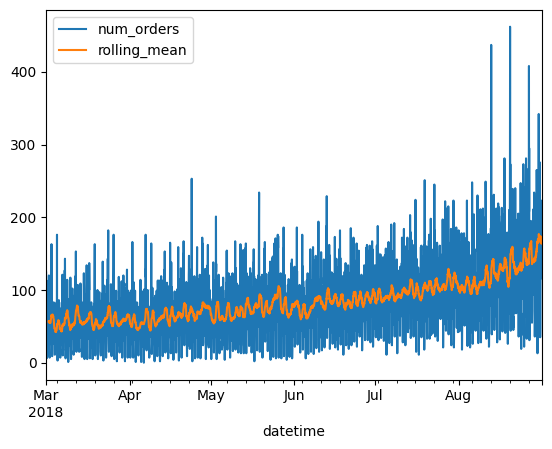

In [5]:
df_hour['rolling_mean'] = df_hour.rolling(24).mean()
print(df_hour.head(25))
df_hour.plot()


Se revisan filas duplicadas

In [6]:
#revisión de filas duplicadas
print(df_hour.duplicated().sum())

46


Ya que la columna que contiene valores únicos (datetime) se fijo esta como índice del DF, este actualmente contiene filas duplicadas. Para solucionar este problema, se añadirán características de calendario, como el año, mes, día, día de la semana y hora del día, que son esenciales para capturar patrones estacionales y tendencias temporales. Además, se incorporarán valores de desfase (lags), los cuales permiten al modelo aprovechar la dependencia temporal de los datos, mejorando su capacidad para predecir valores futuros basados en los registros pasados. Estas modificaciones optimizarán el análisis posterior y la precisión de los modelos.


In [7]:
def make_features(df_hour, max_lag):
    df_hour['year'] = df_hour.index.year
    df_hour['month'] = df_hour.index.month
    df_hour['day'] = df_hour.index.day
    df_hour['dayofweek'] = df_hour.index.dayofweek
    df_hour['hourofday'] = df_hour.index.hour
    
    for lag in range(1, max_lag + 1):
        df_hour['lag_{}'.format(lag)] = df_hour['num_orders'].shift(lag)

    
make_features(df_hour, 4)
print(df_hour.head())

                     num_orders  rolling_mean  year  month  day  dayofweek  \
datetime                                                                     
2018-03-01 00:00:00         124           NaN  2018      3    1          3   
2018-03-01 01:00:00          85           NaN  2018      3    1          3   
2018-03-01 02:00:00          71           NaN  2018      3    1          3   
2018-03-01 03:00:00          66           NaN  2018      3    1          3   
2018-03-01 04:00:00          43           NaN  2018      3    1          3   

                     hourofday  lag_1  lag_2  lag_3  lag_4  
datetime                                                    
2018-03-01 00:00:00          0    NaN    NaN    NaN    NaN  
2018-03-01 01:00:00          1  124.0    NaN    NaN    NaN  
2018-03-01 02:00:00          2   85.0  124.0    NaN    NaN  
2018-03-01 03:00:00          3   71.0   85.0  124.0    NaN  
2018-03-01 04:00:00          4   66.0   71.0   85.0  124.0  


In [8]:
# nuevamente se hace revisión de filas duplicadas para comprobar el efecto de la adición de las columnas
print(df_hour.duplicated().sum())

0


Para comprender mejor la serie temporal, se gráfican las tendencias y la estacionalidad.

Text(0.5, 1.0, 'Residuales')

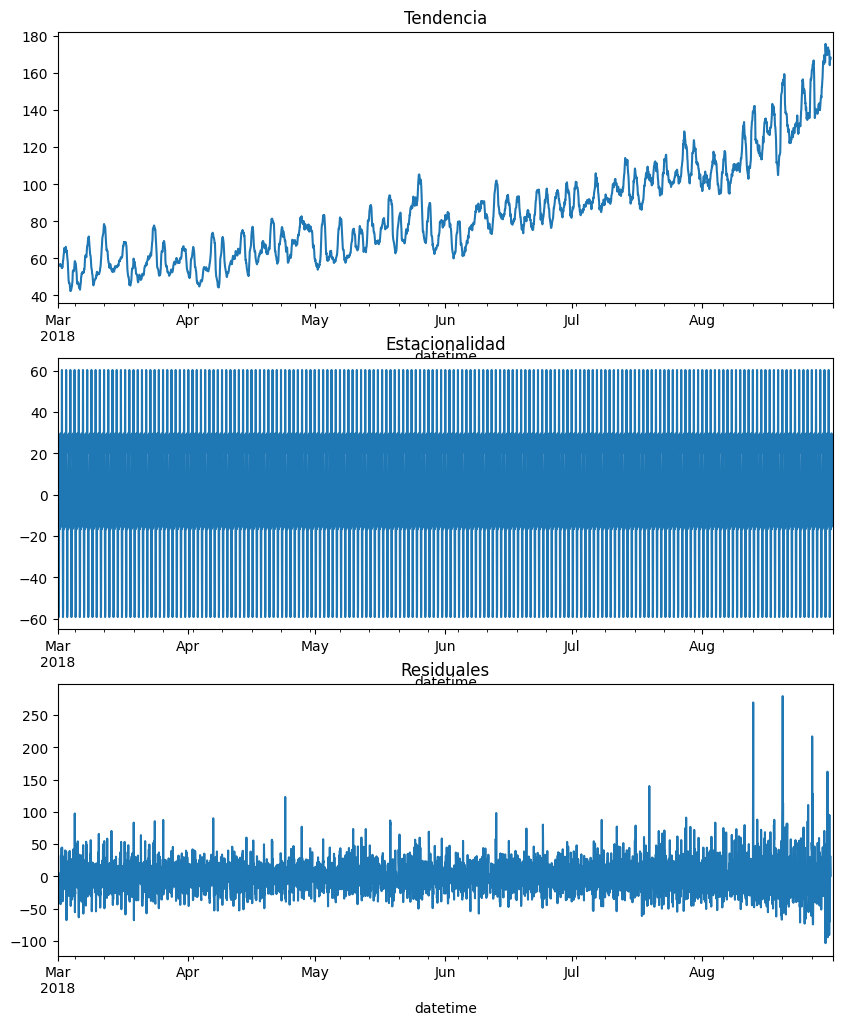

In [9]:

plt.figure(figsize=(10, 12))

plt.subplot(311)
seasonal_decompose(df_hour['num_orders']).trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
seasonal_decompose(df_hour['num_orders']).seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
                   
plt.subplot(313)
seasonal_decompose(df_hour['num_orders']).resid.plot(ax=plt.gca())
plt.title('Residuales')


La primera gráfica revela una tendencia ascendente, ya que a medida que transcurren los meses, la cantidad de taxis solicitados aumenta.

Por su parte, la gráfica de los residuos o ruido muestra la presencia de valores atípicos, destacando un aumento considerable en el último periodo medido.

La gráfica del componente estacional no se muestra de manera clara debido a la gran cantidad de muestras, ya que los datos están registrados por hora. Para una mejor visualización de las características estacionarias voy a re-muestrear los datos a nivel diario.

Text(0.5, 1.0, 'Estacionalidad')

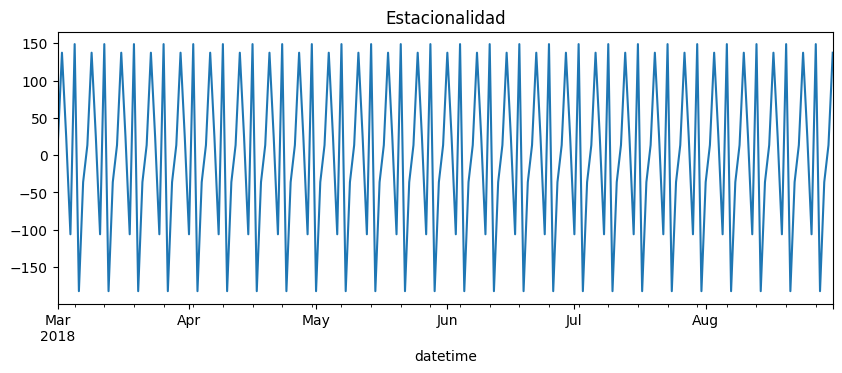

In [10]:
df_day = df.resample('1D').sum()
make_features(df_day, 4)

plt.figure(figsize=(10, 12))

plt.subplot(311)
seasonal_decompose(df_day['num_orders']).seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')



Se observa con mayor claridad que los datos siguen un patrón distintivo a nivel semanal.

Finalmente, agruparé los datos por hora del día para obtener una visión más clara de la tendencia de promedio diaria, ya que el objetivo es predecir el número de pedidos de taxis por hora. Es importante tener una noción de los parámetros normales que las predicciones deberían arrojar y comprender la tendencia horaria para evaluar el rendimiento de las predicciones de los modelos.

<AxesSubplot:xlabel='hourofday'>

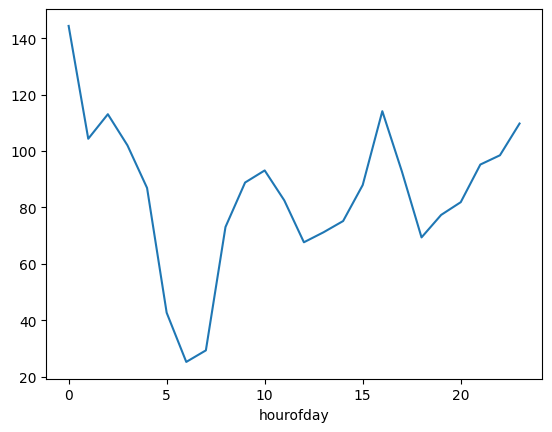

In [11]:
df_hour.groupby('hourofday')['num_orders'].mean().plot()

A partir de las 4 a.m., la demanda de taxis comienza a disminuir, alcanzando su nivel más bajo alrededor de las 6 a.m. En cambio, las horas de mayor demanda se dan aproximadamente a las 3 p.m. y entre las 11 p.m. y las 2 a.m.

## Preparación de los datos

In [12]:
# se eliminan valores ausentes
df_hour = df_hour.dropna()
print(df_hour.head())
df_hour.info()


                     num_orders  rolling_mean  year  month  day  dayofweek  \
datetime                                                                     
2018-03-01 23:00:00          58     56.833333  2018      3    1          3   
2018-03-02 00:00:00          90     55.416667  2018      3    2          4   
2018-03-02 01:00:00         120     56.875000  2018      3    2          4   
2018-03-02 02:00:00          75     57.041667  2018      3    2          4   
2018-03-02 03:00:00          64     56.958333  2018      3    2          4   

                     hourofday  lag_1  lag_2  lag_3  lag_4  
datetime                                                    
2018-03-01 23:00:00         23  113.0   66.0   61.0   45.0  
2018-03-02 00:00:00          0   58.0  113.0   66.0   61.0  
2018-03-02 01:00:00          1   90.0   58.0  113.0   66.0  
2018-03-02 02:00:00          2  120.0   90.0   58.0  113.0  
2018-03-02 03:00:00          3   75.0  120.0   90.0   58.0  
<class 'pandas.core.frame.

In [13]:
# se utiliza shuffle para asegurar que los datos no se mezclen y se respeten las secuencias temporales (pronóstico de series temporales).
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 23:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [14]:
# se preparan los datos de entrada para la regresión (X y Y)
X_train = train.drop(columns=['num_orders']) # features
y_train = train['num_orders']  # target

X_test = test.drop(columns=['num_orders']) # features
y_test = test['num_orders']  # target

## Entrenamiento y analisis de los modelos

Para la predicción del numero de pedidos de taxis, se compararon varios modelos de machine learning, con el objetivo de identificar el más adecuado en términos de precisión medidos bajo la metrica de RECM. Los modelos entrenados son los siguientes:

1. Regresión Lineal
2. Árbol de Decisión
3. Random Forest Regressor
4. LightGBM
5. XGBoost
6. CatBoost

se define función para la obtención del RECM de los diferentes modelos

In [15]:
def calcular_recm(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Modelo 1: Regresión Lineal

In [16]:
# Entrenamiento
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicción
y_pred_lr = lr_model.predict(X_test)

# Evaluación
recm_lr = calcular_recm(y_test, y_pred_lr)
print(f"Regresión Lineal - RECM: {recm_lr}")


Regresión Lineal - RECM: 49.485145854025504


Modelo 2: Árbol de decisión

In [17]:
# Parámetros a ajustar
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11]}

# GridSearchCV para encontrar los mejores hiperparámetros
dt_model = DecisionTreeRegressor(random_state=12345)
grid_search_dt = GridSearchCV(dt_model, param_grid, cv=5, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)


# Mejor modelo
best_dt_model = grid_search_dt.best_estimator_

# Predicción y evaluación

y_pred_dt = best_dt_model.predict(X_test)

recm_dt = calcular_recm(y_test, y_pred_dt)
print(f"Árbol de Decisión - RECM: {recm_dt}")


Árbol de Decisión - RECM: 52.19570521169156


hiperparámetros utilizados:
El único hiperparámetro ajustado fue la max_depth, que determina la profundidad máxima del árbol, el cual seajustó utilizando GridSearchCV, el RECM obtenido fue 52.2, lo que muestra que este modelo fue menos efectivo en comparación con los demas.

Modelo 3: Random Forest Regressor

In [18]:
# Parámetros a ajustar
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [10,20,30,40,50,60,70],
    'max_depth': [1,2,3,4,5,6,7,8]
    
}

# GridSearchCV para encontrar los mejores hiperparámetros
rf_model = RandomForestRegressor(random_state=12345)
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
best_rf_model = grid_search_rf.best_estimator_

# Predicción y evaluación
y_pred_rf = best_rf_model.predict(X_test)
recm_rf = calcular_recm(y_test, y_pred_rf)
print(f"Random Forest - RECM: {recm_rf}")


Random Forest - RECM: 48.693908445498074


hiperparámetros utilizados:
Los hiperparámetros ajustados fueron: max_features (número de características a considerar en cada división del árbol), n_estimators (número de árboles en el bosque) y max_depth (profundidad máxima de cada árbol). El modelo logró un RECM de 48.69, lo que representó una mejora respecto al modelo basado en Árbol de Decisión, alcanzando el límite máximo permitido para la métrica RECM (48).

Modelo 4: LightGBM 

In [19]:
# Entrenamiento del modelo LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=10)
lgb_model.fit(X_train, y_train)

# Predicción y evaluación
y_pred_lgb = lgb_model.predict(X_test)
recm_lgb = calcular_recm(y_test, y_pred_lgb)
print(f"LightGBM - RECM: {recm_lgb}")


LightGBM - RECM: 42.38061459216428


hiperparámetros utilizados:
En este modelo se ajustaron los parámetros learning_rate (tasa de aprendizaje) y n_estimators (número de iteraciones de boosting),alcanzando un RECM de 42.61, el mejor resultado entre todos los modelos.

Modelo 5: XGBoost

Es posible usar XGBoost sin necesidad de convertir los datos a formato DMatrix, aunque este formato es recomendado para optimizar el rendimiento.

In [21]:
# Convertir a formato DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros y entrenamiento
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.05
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100) # num_boost_round reemplaza n_estimators


# Predicción y evaluación

y_pred_xgb = xgb_model.predict(dtest)

recm_xgb = calcular_recm(y_test, y_pred_xgb)
print(f"XGBoost - RECM: {recm_xgb}")


XGBoost - RECM: 48.07526313365094


hiperparámetros utilizados:
En este modelo se ajustaron los parámetros learning_rate (tasa de aprendizaje) y n_estimators (número de iteraciones de boosting). Se obtuvo un RECM de 48.04, ligeramente peor que LightGBM pero aún competitivo.

Modelo 6: CatBoost (Gradient Boosting)

In [22]:
# Entrenamiento de CatBoost
cat_model = CatBoostRegressor(iterations=150, depth=10, learning_rate=0.1, verbose=False) 
cat_model.fit(X_train, y_train)

# Predicción y evaluación
y_pred_cat = cat_model.predict(X_test)

recm_cat = calcular_recm(y_test, y_pred_cat)
print(f"CatBoost - RECM: {recm_cat}")


CatBoost - RECM: 47.605166687244086


hiperparámetros utilizados:
Los hiperparámetros ajustados para optimizar el rendimiento del modelo fueron iterations (el número de iteraciones), depth (profundidad máxima de los árboles) y learning_rate (tasa de aprendizaje), logrando un RECM de 47.61, el segundo mejor resultado.


### Comparación de modelos

La Regresión Lineal obtuvo un RECM de 49.49, mostrando su limitación en comparación con los demás. El Árbol de Decisión alcanzó un RECM de 52.20, lo que lo ubicó como el menos preciso. El Random Forest mostró una mejora con un RECM de 48.69, debido a su capacidad para combinar múltiples árboles. LightGBM fue el mejor con un RECM de 42.61, demostrando su efectividad en tareas de regresión. XGBoost tuvo un RECM de 48.04, ligeramente peor que LightGBM, pero aún competitivo. Finalmente, CatBoost alcanzó un RECM de 47.61, destacándose entre los métodos de boosting, pero sin superar a LightGBM. En resumen, LightGBM sobresalió debido a su balance entre precisión y eficiencia computacional.

## Conclusiones generales:

- Preparación y Análisis Exploratorio de los Datos: Los datos fueron cuidadosamente preparados para su uso en los modelos, comenzando con la conversión de las fechas y la reestructuración de los datos a intervalos horarios. Se llevaron a cabo análisis exploratorios, visualizando tendencias y estacionalidades. Se identificaron patrones claros en la serie temporal, como la variabilidad horaria en la demanda de taxis. Además, se aplicaron técnicas como la media móvil para reducir fluctuaciones y se incorporaron variables de calendario y desfases (lags) para mejorar la predicción.

- Durante la preparación de los datos, tambien se eliminaron los valores ausentes y las filas duplicadas, asegurando la calidad de la información. Además, se dividió el conjunto de datos en entrenamiento y prueba, asegurando que las secuencias temporales fueran respetadas en el entrenamiento de los modelos.

- Entrenamiento y Análisis de Modelos: Se compararon seis modelos de machine learning para la predicción de pedidos de taxis en base a la metrica RECM, siendo el modelo LightGBM el que presentó el mejor rendimiento en términos de precisión, siendo el más efectivo para la predicción del número de pedidos de taxis.
